In [356]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import awkward as ak

In [466]:
Vt = -1.3 #V
Q_max = -30 #pC carica massima per considerare il segnale (Minima in modulo)
Q_min = -1000 #pC tolgo i cosmici

In [489]:
channel = 5

RunCs = uproot.open('../Dati/25_03/Run_chall_Cs_Measurements_Only_3_25_2024_0000.root')

noise_file = '../Dati/Noises/ch' + str(channel) + '.root'
RunNoise = uproot.open(noise_file)



In [490]:

chargeCs = np.array(RunCs['tree'].arrays()['charge'])[:, channel]
ampCs = np.array(RunCs['tree'].arrays()['amp'])[:, channel]

print("#shape array = " + str(np.array(RunCs['tree'].arrays()['charge']).shape))

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

print("evNT = " + str(evNT))
print("evCsT = " + str(evCsT))

T_noises = np.array([0, 0, 213, 0, 1868, 1758, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #Da sistemare e tenere aggiornato


TCs = (56 + 44 * 60 + 4 * 3600)  #s  Da chall del 25/03

rateCs = evCsT / TCs
rateN = evNT / T_noises[channel]

print("rateCs = " + str(rateCs))
print("rateCs corretta = " + str(rateCs * 16))

print("rateN = " + str(rateN))
print("Grandezza ignota = " + str(TCs*rateN))

#shape array = (1000000, 16)
evNT = 300000
evCsT = 1000000
rateCs = 58.493214787084696
rateCs corretta = 935.8914365933551
rateN = 170.64846416382252
Grandezza ignota = 2917406.1433447096


In [491]:
trueCs = ampCs>Vt 
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi che non saturano
ampCs=ampCs[trueCs]


#trueCs = np.logical_and(chargeCs < Q_max, chargeCs > Q_min)
trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale

trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 5 = 63875
#Noise ripulita su ch 5 = 223388


In [492]:
#Aggiorno i tempi di presa dati, che vanno rinormalizzati al numero di eventi rimasti,
#sia per il segnale che per la noise: il tempo "efficace" è dato dal tempo originale 
#riscalato alla frazione di eventi rimasti dopo la pulizia

TCs_eff = TCs * len(chargeCs) / evCsT * 6 / 100 #Prendo 16 canali, quindi devo assumere che il tempo perso a scrivere
                                           #sia 16 volte più grande di quando uso un canale solo
TN_eff  = T_noises[channel]  * len(chargeN)  / evNT

print(TCs_eff)
print(TN_eff)

print ("Rate Cs eff = " + str(len(chargeCs) / TCs_eff))
print ("Rate N eff = " + str(len(chargeN) / TN_eff))

65.52042
1309.05368
Rate Cs eff = 974.8869131180783
Rate N eff = 170.64846416382252


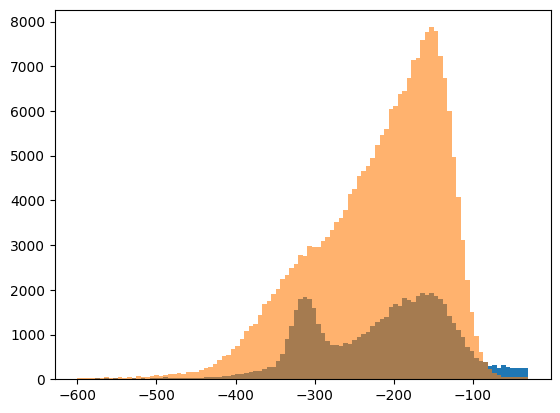

In [493]:
bin = 100

binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-600, Q_max), density = False)
binN , edgeN , _= plt.hist(chargeN, bins=bin, range=(-600, Q_max), alpha=0.6, density = False)

N_sorg = N_noise + N_sign
      = deltaT * (R_noise + R_sign)

N_fondo = N_noise =
        = deltaT * R_noise

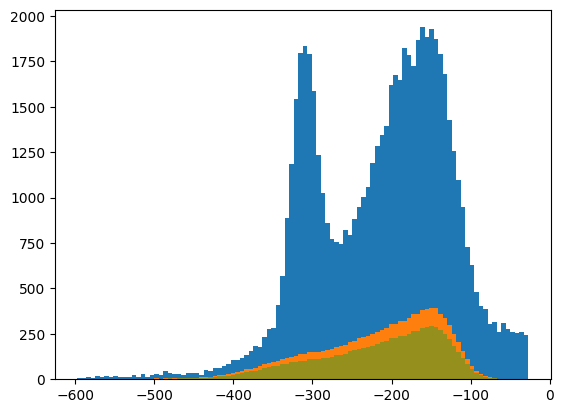

In [529]:
binSign = binCs - binN / TN_eff * TCs_eff * 3

wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:],binCs,width=wdt)
trash = plt.bar(edgeN[1:],binN / TN_eff * TCs_eff ,width=wdt)
trash = plt.bar(edgeN[1:],binN / T_noises[channel]* TCs_eff,width=wdt, alpha = 0.5)



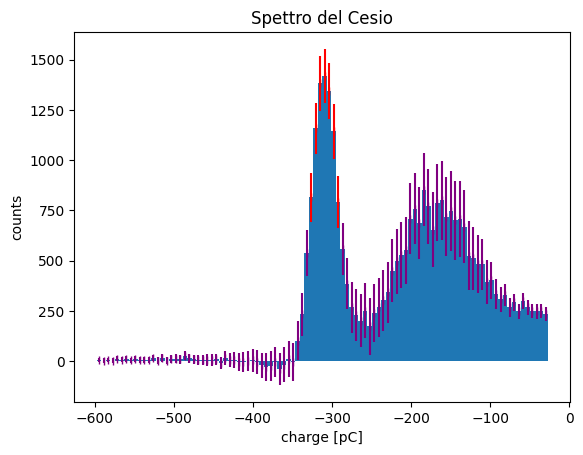

In [530]:
wdt = edgeN[1] - edgeN[0]

trash = plt.bar(edgeN[1:],binSign,width = wdt)

err = np.sqrt(binCs  + binN )

#Determinazione del picco
peak_cntr = np.argmax(binSign)
peak_ledge = peak_cntr - int(bin/30)
peak_redge = peak_cntr + int(bin/25)


trash = plt.errorbar(edgeN[1:peak_ledge+1], binSign[:peak_ledge], err[:peak_ledge]*2, color='purple', fmt='|')
trash = plt.errorbar(edgeN[peak_redge+1:], binSign[peak_redge:], err[peak_redge:]*2, color='purple', fmt='|')

#print(np.size(edgenew[50:70]), np.size(binTot[49:69]), np.size(err[49:69]))
trash = plt.errorbar(edgeN[peak_ledge+1:peak_redge+1], 
                     binSign[peak_ledge:peak_redge], 
                     2*err[peak_ledge:peak_redge], 
                     color='red', fmt='|')



plt.title("Spettro del Cesio")
plt.ylabel("counts")
plt.xlabel("charge [pC]")
plt.show()


-314.9412022284533 10.523094826184543


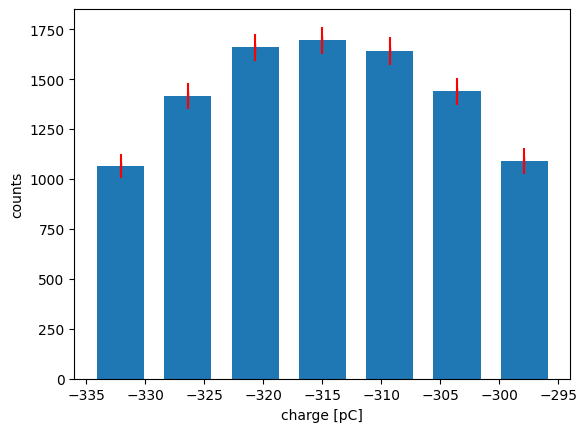

In [523]:
#Isolo la parte di spettro legata al fotoelettrico
edge_photo=edgeN[peak_ledge:peak_redge]
counts_photo=binSign[peak_ledge:peak_redge]
err_photo=err[peak_ledge:peak_redge]
plt.bar(edge_photo,counts_photo,width=4)
plt.errorbar(edge_photo, counts_photo, err_photo, color='red', fmt='|')
plt.ylabel("counts")
plt.xlabel("charge [pC]")


#bin_centers = (edge_photo[:-1] + edge_photo[1:]) / 2
bin_centers=edge_photo
# Calcoliamo il valore rappresentativo pesato dai conteggi di ciascun bin
weighted_values = bin_centers * counts_photo

# Calcoliamo la media pesata
weighted_mean = np.sum(weighted_values) / np.sum(counts_photo)

# Calcoliamo la deviazione standard pesata
weighted_std = np.sqrt(np.sum(counts_photo * (bin_centers - weighted_mean)**2) / np.sum(counts_photo))

print(weighted_mean, weighted_std)


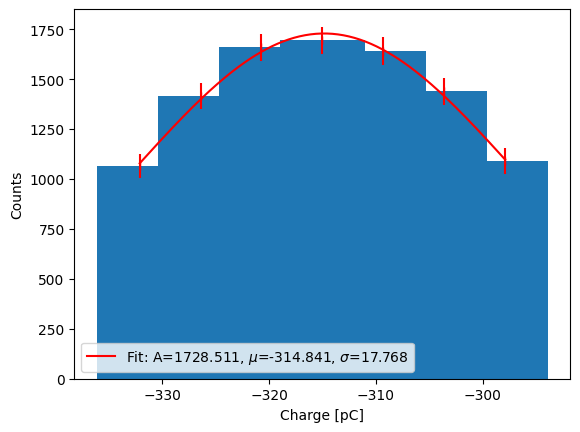

In [524]:
from scipy.optimize import curve_fit



# Definiamo la funzione di fit (ad esempio, una gaussiana)
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# Facciamo il fit della gaussiana ai dati
popt, pcov = curve_fit(gaussian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo,

maxfev = 5000)

# Plot dell'istogramma e della curva di fit
#plt.hist(dati, bins=30, density=True, alpha=0.5, color='b', label='Istogramma dei dati')
plt.bar(edge_photo,counts_photo,width=8)
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt))
plt.errorbar(edge_photo, counts_photo, err_photo, color='red', fmt='|')
plt.legend()
plt.xlabel('Charge [pC]')
plt.ylabel('Counts')
plt.show()


Chi-quadro: 0.6904127320487485
dof: 7


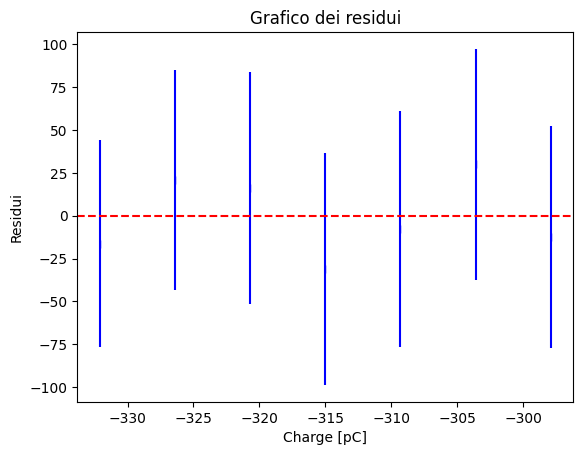

In [512]:
#fare chi quadro e residui
valori_previsti = gaussian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Charge [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

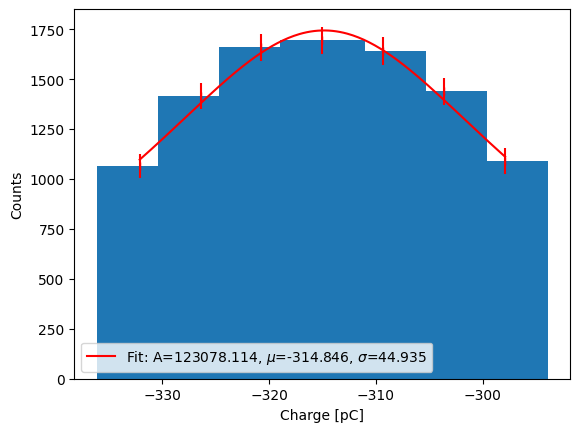

In [499]:
def lorentzian(x, A, x0, L):
    return A / (2 * np.pi) * L / ((x - x0)**2 + (0.5 * L)**2)


popt, pcov = curve_fit(lorentzian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo)

# Plot dell'istogramma e della curva di fit
#plt.hist(dati, bins=30, density=True, alpha=0.5, color='b', label='Istogramma dei dati')
plt.bar(edge_photo,counts_photo,width=8)
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, lorentzian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt))
plt.errorbar(edge_photo, counts_photo, err_photo, color='red', fmt='|')
plt.legend()
plt.xlabel('Charge [pC]')
plt.ylabel('Counts')
plt.show()

Chi-quadro: 22411910.502317842
dof: 7


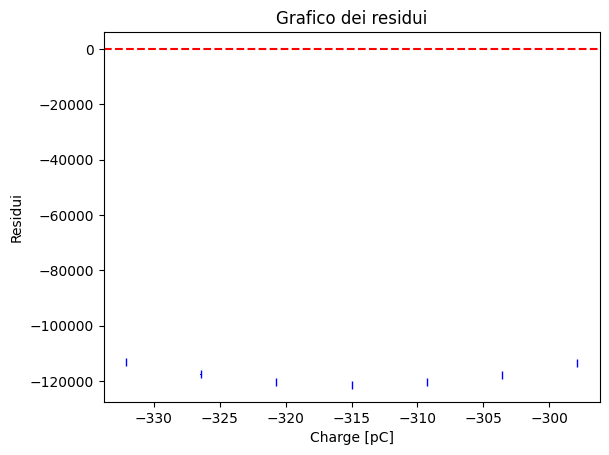

In [500]:
#fare chi quadro e residui
valori_previsti = gaussian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Charge [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

# Stimiamo la carica dalle ampiezze

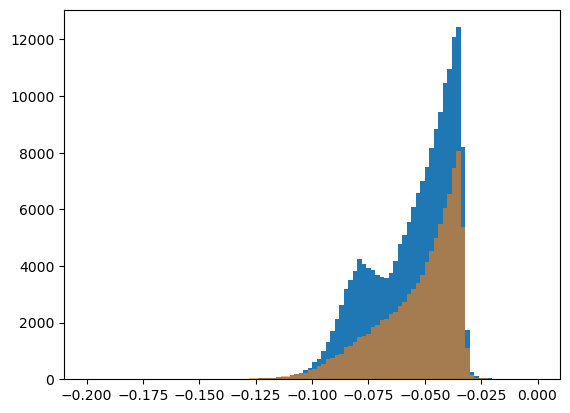

In [311]:
bin=100
ampCs=ampCs[ampCs<0]
ampN=ampN[ampN<0]
bin1,edge1,_ = plt.hist(ampCs, range=(-0.2,0),bins=bin)
bin2,edge2,_= plt.hist(ampN[:100000], range=(-0.2, 0),bins=bin, alpha=0.6)


In [312]:
print(edge1)

[-0.2        -0.198      -0.19599999 -0.19400001 -0.192      -0.19
 -0.18799999 -0.186      -0.184      -0.182      -0.18000001 -0.178
 -0.176      -0.17399999 -0.17200001 -0.17       -0.168      -0.16599999
 -0.164      -0.162      -0.16       -0.15800001 -0.156      -0.154
 -0.152      -0.15000001 -0.148      -0.146      -0.14399999 -0.142
 -0.14       -0.138      -0.13600001 -0.134      -0.132      -0.13
 -0.12800001 -0.126      -0.124      -0.122      -0.12       -0.118
 -0.116      -0.114      -0.112      -0.11       -0.108      -0.106
 -0.104      -0.102      -0.1        -0.098      -0.096      -0.094
 -0.092      -0.09       -0.088      -0.086      -0.084      -0.082
 -0.08       -0.078      -0.076      -0.074      -0.072      -0.07
 -0.068      -0.066      -0.064      -0.062      -0.06       -0.058
 -0.056      -0.054      -0.052      -0.05       -0.048      -0.046
 -0.044      -0.042      -0.04       -0.038      -0.036      -0.034
 -0.032      -0.03       -0.028      -0.026   

'"\ncov=(np.mean(bin1*bin2)-np.mean(bin1)*np.mean(bin2))\nprint(cov)\ncorr=cov/(np.std(bin1)*np.std(bin2))\nprint(corr)\n'

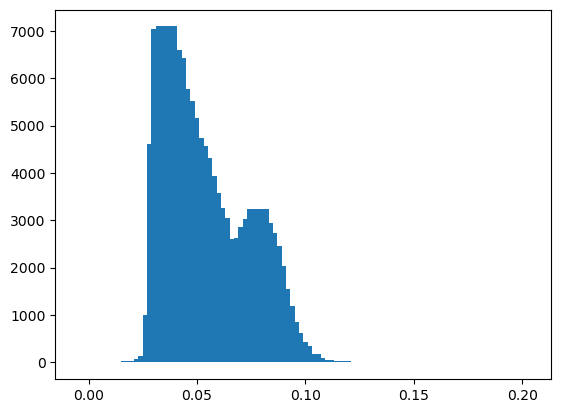

In [313]:
binTot=bin1-(bin2*TCs/TN)
plt.bar(-edge1[1:],binTot, width=0.01)
#plt.xlim(-0.2, 0)
""""
cov=(np.mean(bin1*bin2)-np.mean(bin1)*np.mean(bin2))
print(cov)
corr=cov/(np.std(bin1)*np.std(bin2))
print(corr)
"""


# Con le ampiezze stimate dal fit